# Environment Wrapper for Farm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from mcts import MCTS
from agents import * 
from farmgame import *

# Define the FarmEnv class
class FarmEnv:
    def __init__(self, farm: Farm, reward_function=None):
        self.game = farm  # Accept a Farm instance directly
        self.done = False
        self.reward_function = reward_function or self.default_reward

    def reset(self):
        self.game = configure_game()  # Reset the game
        self.done = False
        return self.get_state()

    def step(self, action):
        current_player = self.game.whose_turn()["name"]
        self.game = self.game.take_action(action, inplace=True)  # Apply action
        reward = self.reward_function(self.game, current_player)  # Calculate reward
        self.done = self.game.is_done()  # Check if game is done
        new_state = self.get_state()  # Get the updated state
        return new_state, reward, self.done, {}  # Return updated state

    def get_state(self):
        return self.game

    def render(self):
        self.game.print_farm()

    def default_reward(self, game, player):
        return game.playersDict[player]["score"]

# Training

In [2]:
def train_q_learning_agent(env, num_episodes=1000, max_steps_per_episode=100):
    # Initialize two Q-learning agents
    agent1 = QLearningAgent(learning_rate=0.1, discount_factor=0.99, epsilon=0.2)
    agent2 = QLearningAgent(learning_rate=0.1, discount_factor=0.99, epsilon=0.2)

    final_rewards_red = []  # To store the final rewards of the 'red' player
    final_rewards_purple = []  # To store the final rewards of the 'purple' player

    for episode in range(num_episodes):
        print(f"\nStarting Episode {episode + 1}/{num_episodes}")

        state = env.reset()  # Reset the environment for a new episode
        agent1.update(state)
        agent2.update(state)

        for step in range(max_steps_per_episode):
            print(f"\nTurn {step + 1}")
            # Agent 1's turn (Red)
            action1 = agent1.choose_action()
            print(f"Red Player Action: {action1}")
            state = state.take_action(action1, inplace=True)

            if state.is_done():  # Check if the game is over
                print("Game Over!")
                break

            # Agent 2's turn (Purple)
            action2 = agent2.choose_action()
            # print(f"Purple Player Action: {action2}")
            state = state.take_action(action2, inplace=True)

            if state.is_done():  # Check if the game is over
                print("Game Over!")
                break

        # Calculate final rewards at the end of the episode
        red_rwd, red_done = state.reward("red")
        purple_rwd, purple_done = state.reward("purple")

        # Record final rewards
        final_rewards_red.append(red_rwd)
        final_rewards_purple.append(purple_rwd)

        print(f"Episode {episode + 1} Completed: Total Red Reward = {red_rwd}, Total Purple Reward = {purple_rwd}")

    print("\nTraining completed.")
    return agent1, agent2, final_rewards_red, final_rewards_purple


In [3]:
farm_instance = configure_game()  # Ensure this function initializes the Farm object correctly
env = FarmEnv(farm_instance)

agent1, agent2, final_rewards_red, final_rewards_purple = train_q_learning_agent(env, num_episodes=1000)


Starting Episode 1/1000

Turn 1
Red Player Action: Tomato00(8,7)
Purple Player Action: Turnip01(13,13)

Turn 2
Red Player Action: Turnip00(12,13)
Purple Player Action: Strawberry01(8,8)

Turn 3
Red Player Action: Strawberry00(7,7)
Purple Player Action: Eggplant00(12,14)

Turn 4
Red Player Action: Tomato01(7,8)
Purple Player Action: Turnip02(13,14)

Turn 5
Red Player Action: box(16,5)
Purple Player Action: box(16,5)
Game Over!
Episode 1 Completed: Total Red Reward = 196, Total Purple Reward = 216

Starting Episode 2/1000

Turn 1
Red Player Action: Turnip00(12,13)
Purple Player Action: Tomato00(8,7)

Turn 2
Red Player Action: Turnip01(13,13)
Purple Player Action: Strawberry01(8,8)

Turn 3
Red Player Action: Tomato01(7,8)
Purple Player Action: Strawberry00(7,7)

Turn 4
Red Player Action: Eggplant00(12,14)
Purple Player Action: Turnip02(13,14)

Turn 5
Red Player Action: redpillow(12,14)
Purple Player Action: box(16,5)

Turn 6
Red Player Action: box(16,5)
Game Over!
Episode 2 Completed: To

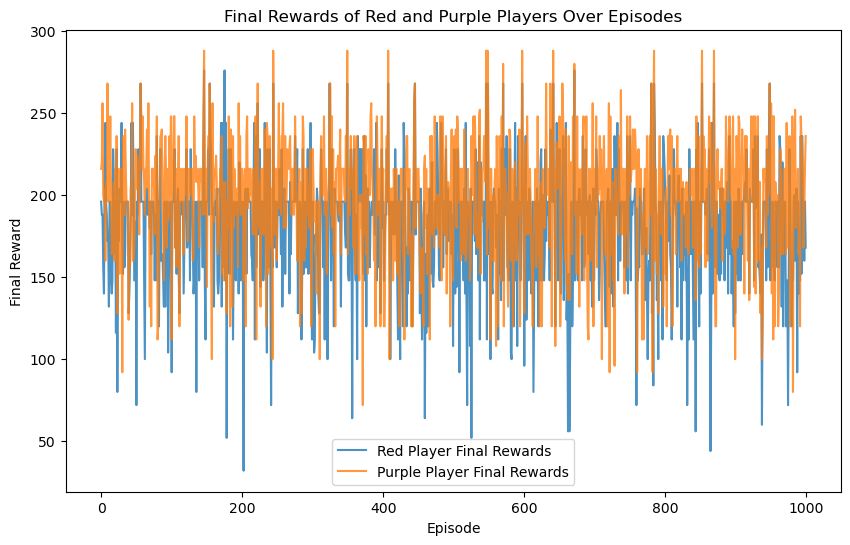

In [4]:
# Plot the final rewards
plt.figure(figsize=(10, 6))
plt.plot(final_rewards_red, label="Red Player Final Rewards", alpha=0.8)
plt.plot(final_rewards_purple, label="Purple Player Final Rewards", alpha=0.8)
plt.xlabel("Episode")
plt.ylabel("Final Reward")
plt.title("Final Rewards of Red and Purple Players Over Episodes")
plt.legend()
plt.show()

In [5]:
# class QLearningAgent:
#     def __init__(self, actions, learning_rate=0.1, discount_factor=0.99, epsilon=0.1):
#         self.q_table = {}  # Dictionary to store Q-values
#         self.actions = actions
#         self.learning_rate = learning_rate
#         self.discount_factor = discount_factor
#         self.epsilon = epsilon

#     def get_q_value(self, state, action):
#         return self.q_table.get((state, action), 0.0)

#     def choose_action(self, state):
#         if random.random() < self.epsilon:  # Explore
#             return random.choice(self.actions)
#         else:  # Exploit
#             q_values = [self.get_q_value(state, a) for a in self.actions]
#             return self.actions[np.argmax(q_values)]

#     def update_q_value(self, state, action, reward, next_state):
#         max_q_next = max([self.get_q_value(next_state, a) for a in self.actions], default=0)
#         td_target = reward + self.discount_factor * max_q_next
#         td_error = td_target - self.get_q_value(state, action)
#         new_q_value = self.get_q_value(state, action) + self.learning_rate * td_error
#         self.q_table[(state, action)] = new_q_value
